In [1]:
# Standard libraries
import os
from glob import glob
import itertools
import pickle

# Basic 3rd party libraries
import pandas as pd
import numpy as np

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# scikit processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

# scikit models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# TensorFlow Keras API
from tensorflow.keras.utils import (
    plot_model as tf_plot,
    to_categorical,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# TensorFlow Keras model and layers API
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dense,
    Dropout,
    Concatenate,
)
from tensorflow.keras.models import (
    Sequential,
    Model,
    load_model as tf_load_model,
)



## Setting configs


In [85]:
# Directory storing the CSI and WLAN captures
resources_dir = resources_dir = "/Volumes/tim_details/tim_honours/CAPTURES"

# Directory to save plots to
plt_dir = "/Users/timothylee/Desktop/Uni/Yr5/Honours/honours_thesis/figures/plt_figs/"

# Directory to save models to
models_dir = "/Volumes/tim_details/tim_honours/models"

# Supress pd scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Resolution of plots
plt.rcParams["figure.dpi"] = 100 # 300
# plt.rcParams["figure.dpi"] = 500 # 300

# Backend to generate plots
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

# plt figure style
fig_style = "seaborn-v0_8-whitegrid"

# colormaps
cmap_qual = "Pastel1"
cmap_seq = "viridis"
cmap_cycl = "twilight"
cmap_intsy = "Blues"

# Hide warnings
import warnings
warnings.filterwarnings("ignore")


## ML Preprocessing

### Reading in total binned df


In [4]:
X = pd.read_hdf(
    os.path.join(resources_dir, "total_wlan.h5"),
    key="wlan",
    mode="r"
)

### Formatting total binned df as time series vector for each instance and feature

In [207]:
# Making each row instance's time series vector for each column's measure
X_features = (
    X
    .sort_values("ts_bins")
    .groupby(["devices", "videos", "instances"])
    .agg({
        # Uplink (with non-data, data, and all frames)
        "frames_up_ndat": lambda x: x.values.tolist(),
        "bytes_up_ndat": lambda x: x.values.tolist(),
        "frames_up_dat": lambda x: x.values.tolist(),
        "bytes_up_dat": lambda x: x.values.tolist(),
        "frames_up_all": lambda x: x.values.tolist(),
        "bytes_up_all": lambda x: x.values.tolist(),
        # Downlink
        "frames_dn_ndat": lambda x: x.values.tolist(),
        "bytes_dn_ndat": lambda x: x.values.tolist(),
        "frames_dn_dat": lambda x: x.values.tolist(),
        "bytes_dn_dat": lambda x: x.values.tolist(),
        "frames_dn_all": lambda x: x.values.tolist(),
        "bytes_dn_all": lambda x: x.values.tolist(),
        # All
        "frames_all_ndat": lambda x: x.values.tolist(),
        "bytes_all_ndat": lambda x: x.values.tolist(),
        "frames_all_dat": lambda x: x.values.tolist(),
        "bytes_all_dat": lambda x: x.values.tolist(),
        "frames_all_all": lambda x: x.values.tolist(),
        "bytes_all_all": lambda x: x.values.tolist(),
    })
)

# Making a DF of the corresponding label combinations of each sample
# Columns: devices, locations, videos, instances
Y = (
    X_features
    .index
    .to_frame()
    .reset_index(drop=True)
    .assign(
        locations=lambda x: x["devices"].str.split(" ").str[1:].str.join(" "),
        devices=lambda x: x["devices"].str.split(" ").str[0],
    )
)


### Setting Y Labels

In [208]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# Using video as label
# TODO: can try out different combinations
labels_to_classify = [
    "devices",
    "locations",
    "videos",
]

# Making label combos to use
y = np.array(
    ["|".join(x) for x in Y[labels_to_classify].values]
)

# Encode the labels
# le = LabelEncoder() # assigns integer encoding
lb = LabelBinarizer() # one-hot encoding|
lb.fit(y)
y_lb = lb.transform(y)

y

array(['PC|200 cm|Vid 1', 'PC|200 cm|Vid 1', 'PC|200 cm|Vid 1', ...,
       'RPi4|50 cm|Vid 9', 'RPi4|50 cm|Vid 9', 'RPi4|50 cm|Vid 9'],
      dtype='<U24')

## Making X features matrix

In [209]:
# Making a 3D features matrix
feature_channels = [
    # (with non-data, data, and all frames)
    # Uplink
    # "frames_up_ndat",
    # "bytes_up_ndat",
    # "frames_up_dat",
    # "bytes_up_dat",
    # "frames_up_all",
    # "bytes_up_all",
    # Downlink
    # "frames_dn_ndat",
    # "bytes_dn_ndat",
    # "frames_dn_dat",
    # "bytes_dn_dat",
    # "frames_dn_all",
    # "bytes_dn_all",
    # All
    # "frames_all_ndat",
    "bytes_all_ndat",
    # "frames_all_dat",
    "bytes_all_dat",
    # "frames_all_all",
    "bytes_all_all",
]

# Axes format is (instance, time, feature_channel)
X_features_matr = (
    np.array(
        X_features[feature_channels].values.tolist()
    )
    .transpose(0, 2, 1)
)

# MinMax scaling the 2D matrix of each feature channel
X_features_matr_scaled = np.zeros(X_features_matr.shape)
# For each feature channel
for i in np.arange(X_features_matr.shape[2]):
    # Scale the 2D (instance, time) matrix
    view = X_features_matr[:, :, i]
    X_features_matr_scaled[:, :, i] = (view - view.min())/(view.max() - view.min())
# Set nan values to 0
X_features_matr_scaled[np.isnan(X_features_matr_scaled)] = 0

### Visualising features to sense check

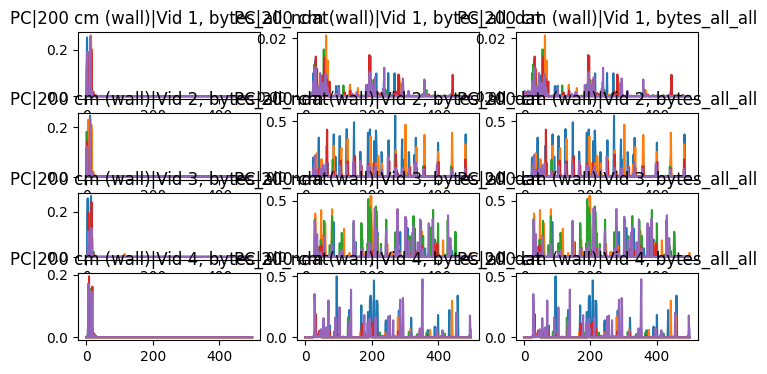

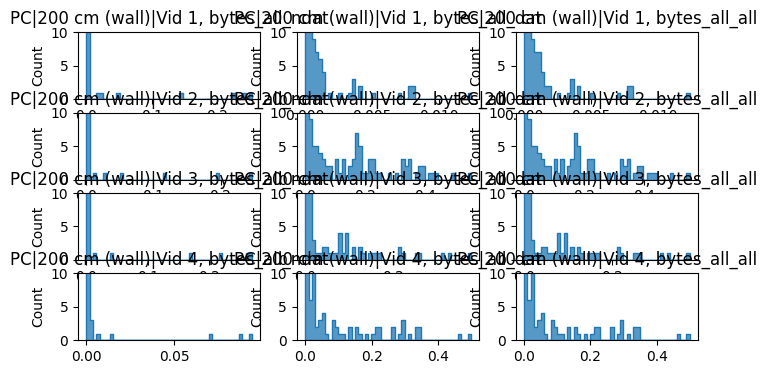

In [210]:
# Line plots through time for some labels
fig = plt.figure(figsize=(8, 4))
axes = fig.subplots(nrows=4, ncols=X_features_matr_scaled.shape[2]).reshape(-1, X_features_matr_scaled.shape[2])
# For each label (given n labels)
for i in np.arange(axes.shape[0]):
    # For each feature channel
    for j in np.arange(axes.shape[1]):
        lab = np.unique(y)[i]
        feature = feature_channels[j]
        axes[i, j].plot(
            X_features_matr_scaled[y == lab][:5, :, j].T
        )
        axes[i, j].set_title(f"{lab}, {feature}")

# Hist plots of each feature's value frequency for some instances
fig = plt.figure(figsize=(8, 4))
axes = fig.subplots(nrows=4, ncols=X_features_matr_scaled.shape[2]).reshape(-1, X_features_matr_scaled.shape[2])
# For each label (given n labels)
for i in np.arange(axes.shape[0]):
    # For each feature channel
    for j in np.arange(axes.shape[1]):
        lab = np.unique(y)[i]
        feature = feature_channels[j]
        sns.histplot(
            (X_features_matr_scaled[y == lab][0, :, j]),
            element="step",
            bins=50,
            ax=axes[i, j],
        )
        axes[i, j].set_ylim(0, 10)
        axes[i, j].set_title(f"{lab}, {feature}")

### Making Training and Test sets

In [211]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features_matr_scaled,
    y_lb,
    test_size=0.2,
    random_state=42,
    stratify=y_lb,
)

# Flattening this data (reshaping) to feed into different ML algos
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3859, 500, 3)
(965, 500, 3)
(3859, 54)
(965, 54)


### Conducting PCA

In [ ]:
# PERFORMING PCA ANALYSIS (IN-CASE)
# Initialize and fit the PCA model
pca = PCA(n_components=10)
pca.fit(np.abs(X_train_flat))

# Transform the data to the lower-dimensional space (and selecting only the top 3 components)
n_components = 2
X_train_pca = pca.transform(np.abs(X_train_flat))[:, :n_components]
X_test_pca = pca.transform(np.abs(X_test_flat))[:, :n_components]

plt.plot(pca.explained_variance_ratio_)
plt.vlines(x=n_components, ymin=0, ymax=pca.explained_variance_ratio_.max(), colors=(0.6,0,0.2))
plt.show()

## Evaluating ML Models

### Helper Funcs to save and eval models

In [326]:
def plot_confusion_matrix(
    cm,
    classes,
    title='Confusion matrix',
    **kwargs
):
    """
    To plot heatmap of confusion matrix
    """
    # Initialising figure and axes
    with plt.style.context(fig_style):
        fig = plt.figure(
            figsize=(8, 8),
            layout="constrained"
        )
        ax = fig.subplots()
    # Making confusion matrix heatmap
    sns.heatmap(
        cm,
        annot=kwargs.get("annot", False),
        ax=ax,
        cmap=kwargs.get("cmap", cmap_intsy),
        fmt=kwargs.get("fmt", ".2f"),
        cbar=kwargs.get("cbar", True),
        xticklabels=classes,
        yticklabels=classes,
    )
    # Set titles
    ax.tick_params(labelsize="small")
    ax.set_title(title, fontsize="xx-large")
    ax.set_xlabel("Predicted", fontsize="large")
    ax.set_ylabel("True", fontsize="large")
    # Return figure and axis
    return fig, ax


def save_res(
    y_true,
    y_pred,
    name,
):
    """
    Saves the results to a folder (given by name)
    """
    # Making directory to store model
    my_model_dir = os.path.join(models_dir, name)
    os.makedirs(my_model_dir, exist_ok=True)
    # Generating and storing results as h5
    res_fp = os.path.join(my_model_dir, f"{name}.h5")
    pd.DataFrame(
        {
            "y_true": y_true,
            "y_pred": y_pred,
        }
    ).to_hdf(res_fp, key="results", mode="w")


def save_pkl(
    obj,
    name,
    suffix=""
):
    """
    Saves the object as a .pkl file to a folder (given by name)
    """
    # Making directory to store model
    my_model_dir = os.path.join(models_dir, name)
    os.makedirs(my_model_dir, exist_ok=True)
    # Storing object as pickle
    obj_fp = os.path.join(my_model_dir, f"{name}_{suffix}.pkl")
    with open(obj_fp, "wb") as f:
        pickle.dump(obj, f)


def load_pkl(
    name,
    suffix=""):
    """
    Loads the .pkl file object from a folder (given by name)
    """
    obj_fp = os.path.join(models_dir, name, f"{name}_{suffix}.pkl")
    # Loading object
    with open(obj_fp, "rb") as f:
        obj = pickle.load(f)
    return obj


def save_model_tf(
    model,
    name,

):
    """
    Saves the TensorFlow Keras model to a folder (given by name)
    """
    # Making directory to store model
    my_model_dir = os.path.join(models_dir, name)
    os.makedirs(my_model_dir, exist_ok=True)
    # Storing model as .keras
    model_fp = os.path.join(my_model_dir, f"{name}.keras")
    model.save(model_fp)

def save_weights_tf(
    model,
    name,
):
    """
    Saves the TensorFlow Keras model weights to a folder (given by name)
    """
    # Making directory to store model
    my_model_dir = os.path.join(models_dir, name)
    os.makedirs(my_model_dir, exist_ok=True)
    # Storing model as .keras
    weights_fp = os.path.join(my_model_dir, f"{name}")
    model.save_weights(weights_fp)


def save_architecture_tf(
    model,
    name
):
    """
    Saves the TensorFlow Keras model architecture to a folder (given by name)
    """
    # Making directory to store model
    my_model_dir = os.path.join(models_dir, name)
    os.makedirs(my_model_dir, exist_ok=True)
    # Saving architecture diagram
    archt_fp = os.path.join(my_model_dir, f"{name}.png")
    tf_plot(
        model,
        to_file=archt_fp,
        show_shapes=True,
        show_dtype=True,
        show_layer_names=False,
        rankdir="TB",
        expand_nested=True,
        show_layer_activations=True,
        show_trainable=False,
    )


def load_model_tf(
    name,
    load_weights=True,
):
    """
    Loads the TensorFlow Keras model from a folder (given by name)
    """
    model_fp = os.path.join(models_dir, name, f"{name}.keras")
    weights_fp = os.path.join(models_dir, name, f"{name}")
    # Loading model
    model = tf_load_model(model_fp)
    # Loading best weights
    if load_weights:
        try:
            model.load_weights(weights_fp)
        except:
            pass
    return model


def eval_model(
    name,
    lab_grouping=None,
):
    """
    Evaluate the given model from the saved model pickle and results h5.
    Can also group on the given labels (e.g., only (devices, videos))
    """
    # Reading in results
    res = pd.read_hdf(
        os.path.join(models_dir, name, f"{name}.h5"),
        key="results",
        more="r"
    )
    # Making label groupings for evaluation
    if lab_grouping:
        res = res.assign(
            y_true=lambda x: ["|".join(i) for i in np.array(res["y_true"].str.split("|").values.tolist())[:, lab_grouping]],
            y_pred=lambda x: ["|".join(i) for i in np.array(res["y_pred"].str.split("|").values.tolist())[:, lab_grouping]],
        )

    # Getting classes
    classes = np.sort(res["y_true"].unique())

    # Making confusion matrix
    # rows = true, columns = predicted
    cm = confusion_matrix(
        y_true=res["y_true"],
        y_pred=res["y_pred"],
        labels=classes,
        normalize=None,
    )
    # Plotting confusion matrix
    plot_confusion_matrix(
        cm,
        classes,
        title=f"{name} Classifier Results",
        annot=True,
        cmap="Blues",
        fmt=".0f",
    )
    # Classification report
    print(classification_report(
        res["y_true"],
        res["y_pred"],
        target_names=classes,
    ))

### KNN

                          precision    recall  f1-score   support

  PC|200 cm (wall)|Vid 1       0.28      0.37      0.32        19
  PC|200 cm (wall)|Vid 2       0.17      0.27      0.21        11
  PC|200 cm (wall)|Vid 3       0.17      0.20      0.19        20
  PC|200 cm (wall)|Vid 4       0.19      0.30      0.24        20
  PC|200 cm (wall)|Vid 5       0.24      0.33      0.28        12
  PC|200 cm (wall)|Vid 6       0.27      0.39      0.32        18
  PC|200 cm (wall)|Vid 7       0.17      0.21      0.19        19
  PC|200 cm (wall)|Vid 8       0.24      0.42      0.30        12
  PC|200 cm (wall)|Vid 9       0.15      0.17      0.16        18
         PC|200 cm|Vid 1       0.33      0.32      0.32        19
         PC|200 cm|Vid 2       0.53      0.47      0.50        17
         PC|200 cm|Vid 3       0.48      0.53      0.50        19
         PC|200 cm|Vid 4       0.50      0.26      0.34        19
         PC|200 cm|Vid 5       0.56      0.29      0.38        17
         

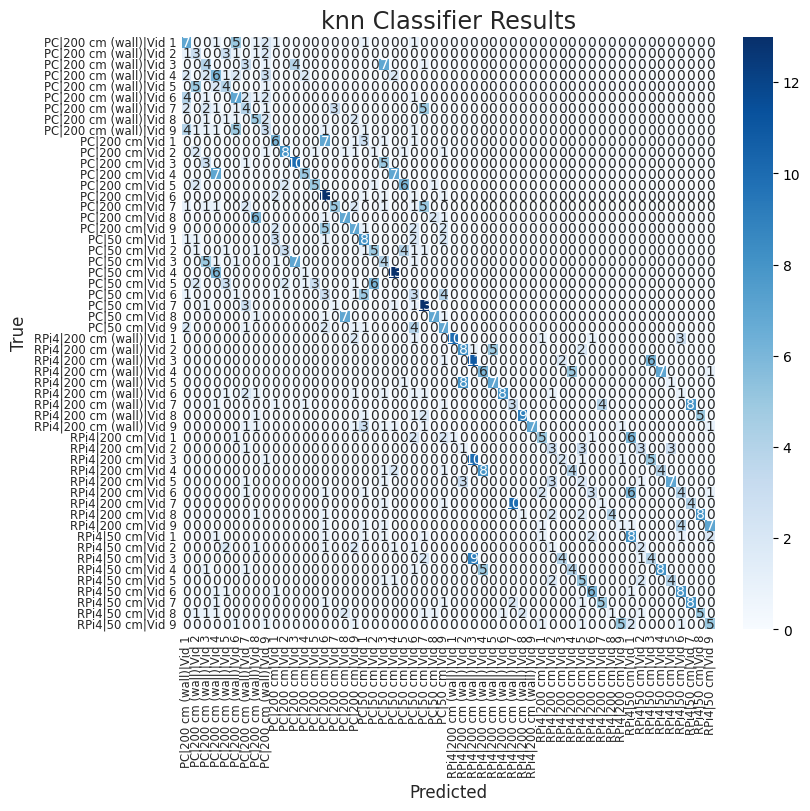

In [239]:
# KNN WORKS VERY WELL!! Fast with PCA.
# 1-NN seems to work best

name = "knn"

# Making KNN
model = KNeighborsClassifier(
    n_neighbors=1,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None
)

# Training
model.fit(X_train_flat, y_train)
# model.fit(X_train_pca, y_train)

# Saving the model
save_pkl(
    model,
    name,
    suffix="model",
)

# Evaluating (from saved model)
model = load_pkl(
    name,
    suffix="model",
)
y_pred = model.predict(X_test_flat)
# y_pred = model.predict(X_test_pca)

# Saving the results
save_res(
    lb.inverse_transform(y_test),
    lb.inverse_transform(y_pred),
    name,
)
# Showing results
eval_model(name, [0, 1, 2])

### SVM (One vs Rest)

                          precision    recall  f1-score   support

  PC|200 cm (wall)|Vid 1       0.03      1.00      0.05        19
  PC|200 cm (wall)|Vid 2       0.00      0.00      0.00        11
  PC|200 cm (wall)|Vid 3       1.00      0.05      0.10        20
  PC|200 cm (wall)|Vid 4       0.50      0.05      0.09        20
  PC|200 cm (wall)|Vid 5       0.00      0.00      0.00        12
  PC|200 cm (wall)|Vid 6       0.00      0.00      0.00        18
  PC|200 cm (wall)|Vid 7       0.00      0.00      0.00        19
  PC|200 cm (wall)|Vid 8       1.00      0.08      0.15        12
  PC|200 cm (wall)|Vid 9       0.00      0.00      0.00        18
         PC|200 cm|Vid 1       1.00      0.32      0.48        19
         PC|200 cm|Vid 2       0.67      0.12      0.20        17
         PC|200 cm|Vid 3       0.33      0.16      0.21        19
         PC|200 cm|Vid 4       0.50      0.11      0.17        19
         PC|200 cm|Vid 5       1.00      0.06      0.11        17
         

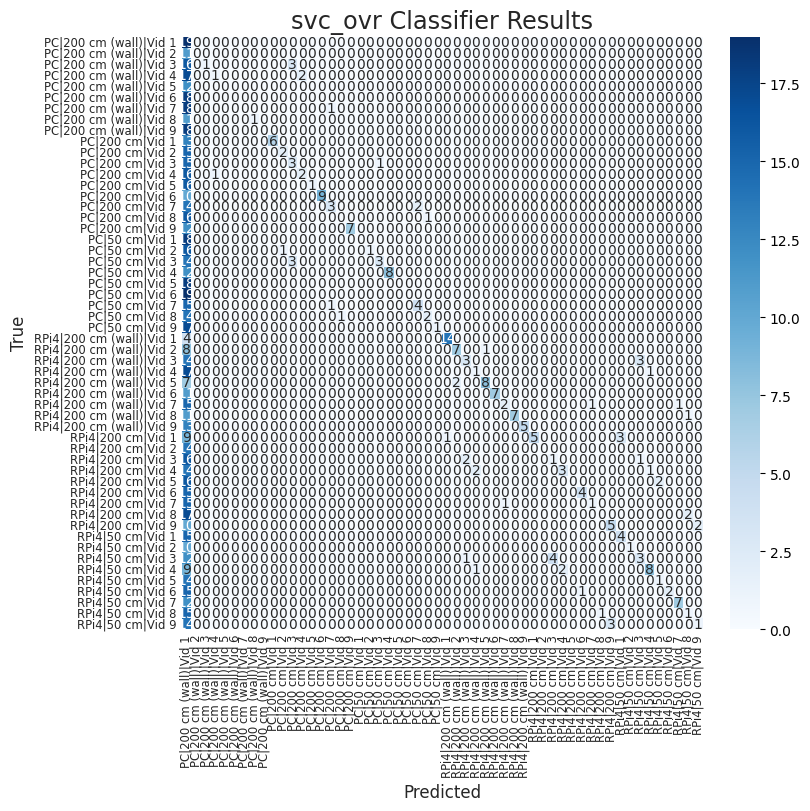

In [240]:
# SVM OVR is similar performance to KNN but much slower

name = "svc_ovr"

# Making RBF SVC
model = SVC(
    C=2.0, # Regularisation parameter. Reg strength is inversely proportional to C
    kernel='rbf', # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable
    # degree=3, # Degree for poly kernels
    gamma='scale', # {‘scale’, ‘auto’} or float
    coef0=0.0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
    shrinking=True, # Whether to use the shrinking heuristic
    probability=False, # Allows predict_proba but slows down process
    tol=0.001, # Tolerance for stopping criterion.
    cache_size=200, # Specify the size of the kernel cache in MB
    class_weight=None, # Set the parameter C of class i to class_weight[i]*C. Keep as none for equal weights across classes
    verbose=False, # Enable verbose output
    max_iter=-1, # Hard limit on iterations within solver, or -1 for no limit
    decision_function_shape='ovr', # {‘ovo’, ‘ovr’}
    break_ties=False,
    random_state=None
)
model = OneVsRestClassifier(
    model,
    n_jobs=4,
)

# Training
model.fit(X_train_flat, y_train)
# model.fit(X_train_pca, y_train)

# Saving the model
save_pkl(
    model,
    name,
    suffix="model",
)

# Evaluating (from saved model)
model = load_pkl(
    name,
    suffix="model",
)
y_pred = model.predict(X_test_flat)
# y_pred = model.predict(X_test_pca)

# Saving the results
save_res(
    lb.inverse_transform(y_test),
    lb.inverse_transform(y_pred),
    name,
)
# Showing results
eval_model(name, [0, 1, 2])

### SVM (One vs One)

                          precision    recall  f1-score   support

  200 cm (wall)|PC|Vid 1       0.28      0.68      0.39        19
  200 cm (wall)|PC|Vid 2       0.44      0.36      0.40        11
  200 cm (wall)|PC|Vid 3       0.55      0.30      0.39        20
  200 cm (wall)|PC|Vid 4       0.33      0.20      0.25        20
  200 cm (wall)|PC|Vid 5       0.42      0.42      0.42        12
  200 cm (wall)|PC|Vid 6       0.32      0.50      0.39        18
  200 cm (wall)|PC|Vid 7       0.50      0.11      0.17        19
  200 cm (wall)|PC|Vid 8       0.75      0.50      0.60        12
  200 cm (wall)|PC|Vid 9       0.25      0.17      0.20        18
200 cm (wall)|RPi4|Vid 1       0.82      0.78      0.80        18
200 cm (wall)|RPi4|Vid 2       0.56      0.62      0.59        16
200 cm (wall)|RPi4|Vid 3       0.30      0.30      0.30        20
200 cm (wall)|RPi4|Vid 4       0.67      0.53      0.59        19
200 cm (wall)|RPi4|Vid 5       0.75      0.71      0.73        17
200 cm (w

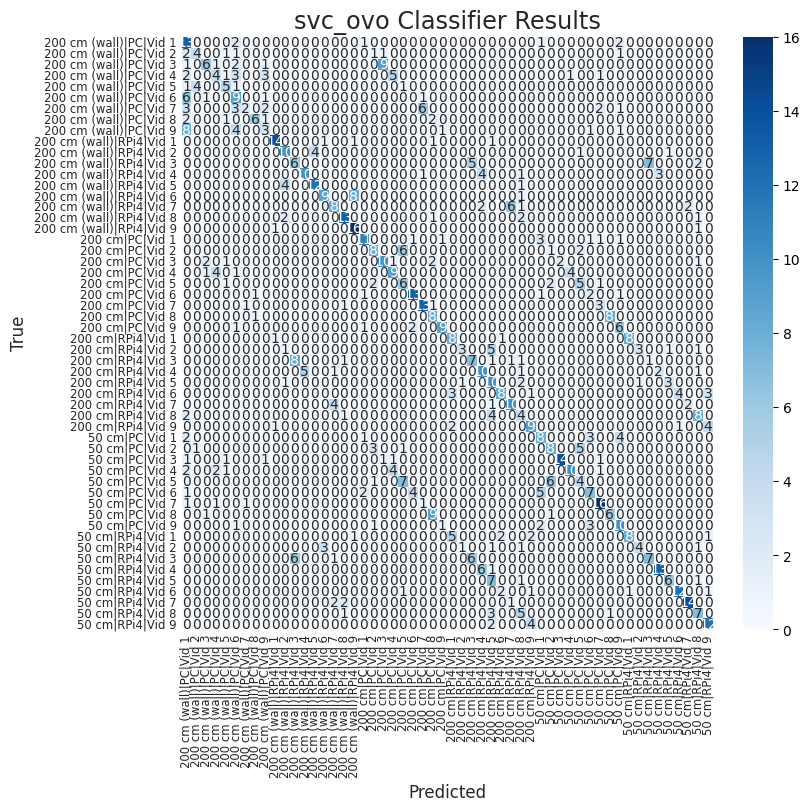

In [163]:
# SVM OVO is ~ 0.78% accuracy.

name = "svc_ovo"

# Making RBF SVC
model = SVC(
    C=2.0, # Regularisation parameter. Reg strength is inversely proportional to C
    kernel='rbf', # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable
    # degree=3, # Degree for poly kernels
    gamma='scale', # {‘scale’, ‘auto’} or float
    coef0=0.0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
    shrinking=True, # Whether to use the shrinking heuristic
    probability=False, # Allows predict_proba but slows down process
    tol=0.001, # Tolerance for stopping criterion.
    cache_size=200, # Specify the size of the kernel cache in MB
    class_weight=None, # Set the parameter C of class i to class_weight[i]*C. Keep as none for equal weights across classes
    verbose=False, # Enable verbose output
    max_iter=-1, # Hard limit on iterations within solver, or -1 for no limit
    decision_function_shape='ovo', # {‘ovo’, ‘ovr’}
    break_ties=False,
    random_state=None
)
model = OneVsOneClassifier(
    model,
    n_jobs=4,
)

# Converting binarised labels (vectors) to encoded (single val)
le = LabelEncoder()
y_le_train = le.fit_transform(lb.inverse_transform(y_train))
y_le_test = le.transform(lb.inverse_transform(y_test))

# Training
model.fit(X_train_flat, y_le_train)
# model.fit(X_train_pca, y_le_train)

# Saving the model
save_pkl(
    model,
    name,
    suffix="model",
)

# Evaluating (from saved model)
model = load_pkl(
    name,
    suffix="model",
)
y_pred = model.predict(X_test_flat)
# y_pred = model.predict(X_test_pca)

# Saving the results
save_res(
    le.inverse_transform(y_le_test),
    le.inverse_transform(y_pred),
    name,
)
# Showing results
eval_model(name, [0, 1, 2])

## Deep Learning Models

In [347]:
from keras.src.saving.saving_api import load_weights
def make_checkpoint_cb(name):
    """
    Make the ModelCheckpoint callback to save the model during training.
    """
    # Making directory to store model
    my_model_dir = os.path.join(models_dir, name)
    os.makedirs(my_model_dir, exist_ok=True)
    # Making model checkpoint callback
    checkpoint_fp = os.path.join(my_model_dir, f"{name}")
    cp_callback = ModelCheckpoint(
        filepath=checkpoint_fp,
        verbose=1,
        save_weights_only=True,
        save_freq="epoch",
        monitor="val_categorical_accuracy",
        mode="max",
        save_best_only=True,
    )
    # Returning callback
    return cp_callback


def train_tf(
    name,
    hparams,
    X_train,
    y_train,
):
    """
    Trains a TensorFlow Keras model.
    Steps are:
        - Configure the model for training
        - Training the model
        - Saving the model
    """
    # Loading model
    model = load_model_tf(name, load_weights=False)

    # Remove old weights
    for i in ["checkpoint", ".index", ".data"]:
        fps = glob(os.path.join(models_dir, name, f"*{i}*"))
        [os.remove(fp) for fp in fps]

    # Configure the model for training
    model.compile(
        optimizer=Adam(
            learning_rate=hparams["learning_rate"],
        ),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(),
        ],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
        steps_per_execution=None,
        jit_compile=None,
        pss_evaluation_shards=0,
    )

    # Training the model
    history = model.fit(
        X_train,
        y_train,
        epochs=hparams["epochs"],
        batch_size=hparams["batch_size"],
        validation_split=hparams["validation_split"],
        verbose=hparams["verbose"],
        callbacks=[
            make_checkpoint_cb(name),
        ],
        use_multiprocessing=True,
    )

    # Saving the model
    save_model_tf(model, name)
    # Saving model history
    save_pkl(
        history,
        name,
        suffix="history",
    )
    # Saving model hyperparams
    save_pkl(
        hparams,
        name,
        suffix="hparams",
    )

def eval_tf(
    name,
    X_test,
    y_test,
    lab_grouping=None,
):
    """
    Evaluates a TensorFlow Keras model.
    Steps are:
        - Evaluating (from saved model)
        - Saving the results
        - Showing results
    """
    # Loading model
    model = load_model_tf(name)

    # Loading history
    history = load_pkl(name, suffix="history")

    # Predicting the test labels
    y_probs = model.predict(X_test)
    # Converting y_pred from softmax probs to outcome
    y_pred = to_categorical(y_probs.argmax(axis=1), y_probs.shape[1]).astype(int)

    # Saving the results
    save_res(
        lb.inverse_transform(y_test),
        lb.inverse_transform(y_pred),
        name,
    )
    # Showing results
    eval_model(name, lab_grouping)

    # Showing training convergence
    h = pd.DataFrame(history.history)
    with plt.style.context(fig_style):
        fig, axes = plt.subplots(ncols=2)
    for i_k, i_v in enumerate(["loss", "categorical_accuracy"]):
        sns.lineplot(
            data=(
                h[[f"{j}{i_v}" for j in ["", "val_"]]]
                .melt(ignore_index=False)
                .reset_index()
            ),
            x="index",
            y="value",
            hue="variable",
            palette=cmap_qual,
            ax=axes[i_k],
        )
        axes[i_k].set_title(f"{i_v}")


### MLP Model

Model: "MLP_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_75 (InputLayer)       [(None, 500, 3)]          0         
                                                                 
 MLP_V1 (Sequential)         (None, 54)                394262    
                                                                 
Total params: 394262 (1.50 MB)
Trainable params: 394262 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
40/49 [=======================>......] - ETA: 0s - loss: 3.9448 - categorical_accuracy: 0.0359
Epoch 1: val_categorical_accuracy improved from -inf to 0.09326, saving model to /content/drive/MyDrive/honours/models/MLP_V1/MLP_V1
49/49 [==============================] - 2s 10ms/step - loss: 3.9305 - categorical_accuracy: 0.0385 - val_loss: 3.7986 - val_categorical_accuracy: 0.0933
Epoch 2/1000
46/49 [=====

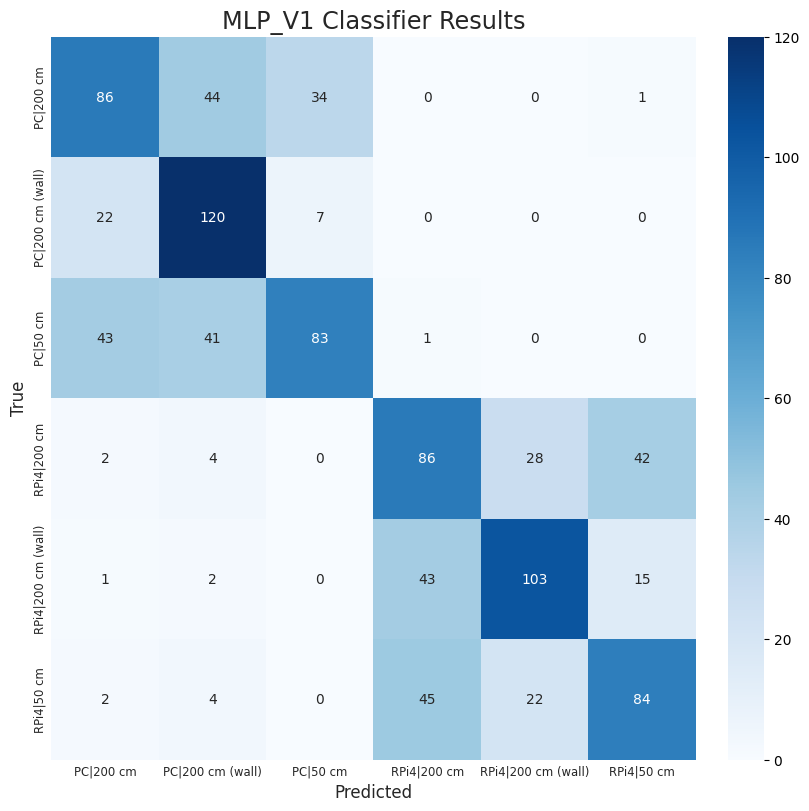

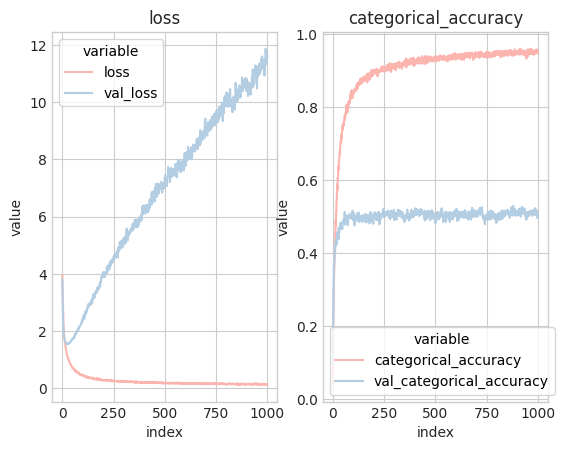

In [349]:
# Simpler CNN. Accuracy ~ 0.88

name = "MLP_V1"

# Hyper-parameters
hparams = {
    "epochs": 1000,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
}

# Making CNN model Architecture
in1 = Input(shape=X_train.shape[1:])
m1 = Sequential(
    [
        Flatten(
            name="flatten",
        ),
        Dense(
            256, activation="relu", name="dense_1",
        ),
        Dense(
            32, activation="relu", name="dense_2",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            len(lb.classes_), activation="softmax", name="output"
        )
    ],
    name="MLP_V1"
)(in1)

model = Model(
    inputs=[in1],
    outputs=[m1],
    name=name,
)

# Show model architecture
model.summary()

# Saving model
save_model_tf(model, name)
# Save architecture
save_architecture_tf(model, name)

# Training model
# train_tf(name, hparams, X_train, y_train)

# Evaluating model
eval_tf(name, X_test, y_test, [0, 1])


### CNN Model V1

Model: "CNN_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_83 (InputLayer)       [(None, 500, 3)]          0         
                                                                 
 CNN_V1 (Sequential)         (None, 54)                256006    
                                                                 
Total params: 256006 (1000.02 KB)
Trainable params: 256006 (1000.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
31/31 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    PC|Vid 1       0.81      0.86      0.83        56
    PC|Vid 2       0.77      0.74      0.76        46
    PC|Vid 3       0.90      0.93      0.92        59
    PC|Vid 4       0.88      0.98      0.93        59
    PC|Vid 5       0.83      0.81      0.82        47
    PC|Vid 6       0.74      0.82   

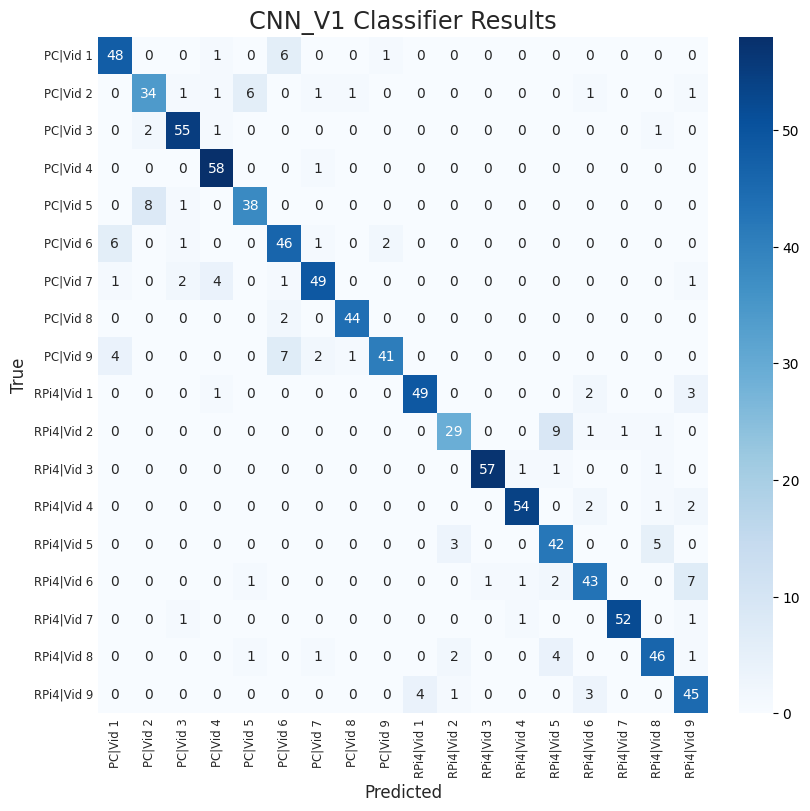

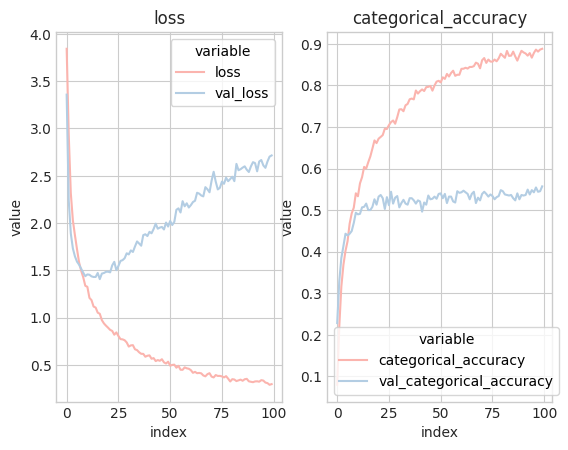

In [ ]:
# Simpler CNN. Accuracy ~ 0.88

name = "CNN_V1"

# Hyper-parameters
hparams = {
    "epochs": 100,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
}

# Making CNN model Architecture
in1 = Input(shape=X_train.shape[1:])
m1 = Sequential(
    [
        Conv1D(
            8, 5, padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling1D(
            2, name="maxpool_1",
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_2",
        ),
        Flatten(
            name="flatten",
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            len(lb.classes_), activation="softmax", name="output"
        )
    ],
    name="CNN_V1"
)(in1)

model = Model(
    inputs=[in1],
    outputs=[m1],
    name=name,
)

# Show model architecture
model.summary()

# Saving model
save_model_tf(model, name)
# Save architecture
save_architecture_tf(model, name)

# Training model
# train_tf(name, hparams, X_train, y_train)

# Evaluating model
eval_tf(name, X_test, y_test, [0, 2])


### CNN Model V2
From Deep Content paper

Model: "CNN_V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_78 (InputLayer)       [(None, 500, 3)]          0         
                                                                 
 CNN_V2 (Sequential)         (None, 54)                264278    
                                                                 
Total params: 264278 (1.01 MB)
Trainable params: 264278 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
37/49 [=====================>........] - ETA: 0s - loss: 3.9887 - categorical_accuracy: 0.0190
Epoch 1: val_categorical_accuracy improved from -inf to 0.03627, saving model to /content/drive/MyDrive/honours/models/CNN_V2/CNN_V2
49/49 [==============================] - 2s 10ms/step - loss: 3.9850 - categorical_accuracy: 0.0201 - val_loss: 3.9592 - val_categorical_accuracy: 0.0363
Epoch 2/1000
39/49 [=====

                          precision    recall  f1-score   support

  PC|200 cm (wall)|Vid 1       0.24      1.00      0.39        19
  PC|200 cm (wall)|Vid 2       0.00      0.00      0.00        11
  PC|200 cm (wall)|Vid 3       0.37      0.35      0.36        20
  PC|200 cm (wall)|Vid 4       0.80      0.20      0.32        20
  PC|200 cm (wall)|Vid 5       0.67      1.00      0.80        12
  PC|200 cm (wall)|Vid 6       0.00      0.00      0.00        18
  PC|200 cm (wall)|Vid 7       0.47      0.42      0.44        19
  PC|200 cm (wall)|Vid 8       1.00      0.83      0.91        12
  PC|200 cm (wall)|Vid 9       0.00      0.00      0.00        18
         PC|200 cm|Vid 1       0.00      0.00      0.00        19
         PC|200 cm|Vid 2       0.40      0.35      0.38        17
         PC|200 cm|Vid 3       0.00      0.00      0.00        19
         PC|200 cm|Vid 4       0.00      0.00      0.00        19
         PC|200 cm|Vid 5       0.25      0.06      0.10        17
         

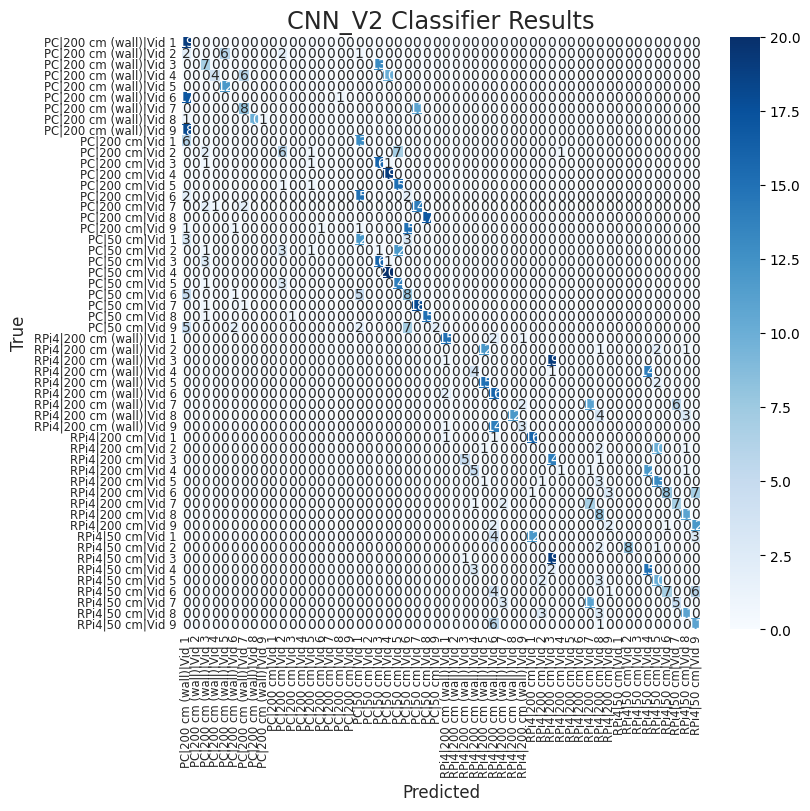

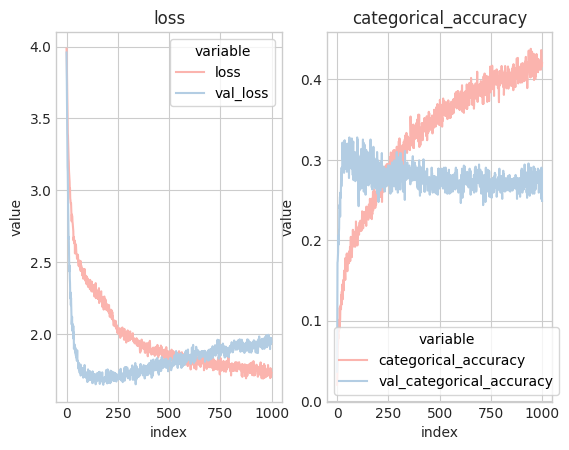

In [352]:
# Simpler CNN. Accuracy ~ 0.88

name = "CNN_V2"

# Hyper-parameters
hparams = {
    "epochs": 1000,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
}

# Making CNN model Architecture
in1 = Input(shape=X_train.shape[1:])
m1 = Sequential(
    [
        Conv1D(
            32, (16,), padding="valid", activation="relu", name="conv_1",
        ),
        Conv1D(
            32, (16,), padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling1D(
            2, name="maxpool_1",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Flatten(
            name="flatten",
        ),
        Dense(
            32, activation="relu", name="dense_1",
        ),
        Dropout(
            0.7, name="dropout_2"
        ),
        Dense(
            64, activation="relu", name="dense_2",
        ),
        Dropout(
            0.5, name="dropout_3"
        ),
        Dense(
            len(lb.classes_), activation="softmax", name="output"
        )
    ],
    name="CNN_V2"
)(in1)

model = Model(
    inputs=[in1],
    outputs=[m1],
    name=name,
)

# Show model architecture
model.summary()

# Saving model
save_model_tf(model, name)
# Save architecture
save_architecture_tf(model, name)

# Training model
train_tf(name, hparams, X_train, y_train)

# Evaluating model
eval_tf(name, X_test, y_test)


In [ ]:
# https://www.educative.io/answers/how-to-merge-two-different-models-in-keras

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Input, Dense, Concatenate, Dropout
from keras.models import Model
from keras.utils import plot_model

# Model A
a_ip_img = Input(shape=(32,32,1), name="Input_a")
al_1 = Dense(64, activation = "relu",name ="a_layer_1")(a_ip_img)
al_2 = Dense(128, activation="relu",name ="a_layer_2")(al_1)
al_3 = Dense(64, activation="relu",name ="a_layer_3")(al_2)
al_4 = Dense(32, activation="sigmoid",name ="a_output_layer")(al_3)

#Model B
b_ip_img = Input(shape=(32,32,1), name="Input_b")
bl_1 = Dense(64, activation="relu",name ="b_layer_1")(b_ip_img)
bl_2 = Dense(32, activation = "sigmoid",name ="b_output_layer")(bl_1)

#Merging model A and B
a_b = Concatenate(axis=0,name="concatenated_layer")([al_4,bl_2])

# Dropout layer
a_d = Dropout(0.5)(a_b)
#Final Layer
output_layer = Dense(16, activation = "sigmoid", name = "output_layer")(a_d)

#Model Definition
merged = Model(inputs=[(a_ip_img,b_ip_img)],outputs=[output_layer], name = "merged model")

#Model Details
merged.summary()
keras.utils.plot_model(
    merged,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=True,
    show_layer_activations=True,
    show_trainable=False,
)



